In [3]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [4]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

In [5]:
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['text.usetex'] = False
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes', labelsize=12)
mpl.rcParams['figure.dpi'] = 300

# Regression and Classification

Written by: [Matthew R. Carbone](https://www.bnl.gov/staff/mcarbone) | _Assistant Computational Scientist, Computational Science Initiative, Brookhaven National Laboratory_

In this tutorial, we're going to go over the fundamentals of regression and classification, which are the two most common types of supervised learning. We will also discuss some of the best practices in machine learning, such as a train-validation-testing split. In regression problems, the objective is to learn a _continuous_ output. In classification problems, the objective is to learn a _discrete_ output. Here are some examples:
- Predicting the cost of a house from its properties, such as square footage, number of bathrooms, etc. is a _regression_ problem.
- Whether or not an image is of a cat or dog is a _classification_ problem.
- Predicting the type of animal in an image is a _classification_ problem.

**Learning objectives:**
- Understand a variety of regression and classification algorithms.
- Start to explore some of the fundamental concepts in machine learning, such as splitting data, overfitting, etc.

Regression and classification problems can be solved via a variety of different methods (or _models_). In this tutorial, we're going to go over the following types of models, which will form the backbone of your understanding for e.g. neural networks, and other types of machine learning, later on.
- Linear regression
- Polynomial regression
- Logistic regression

There are numerous [other types of models](https://www.listendata.com/2018/03/regression-analysis.html#Linear-Regression) which we simply won't have the time to dive into, but paradigmatically, the objective of all of these models is the same. Given some input, predict some output.

## Ingredients for regression

There are a few "ingredients" to always consider when approaching a regression problem.
- Your available data ("dataset")
- Your choice of model ("model")
- How you choose to fit the model to the data ("optimizer")
- An indicator for how well your model fits the data ("loss function"/"metric"/"criterion")

We will discuss all of these components today.

## Other resources

- [Andrew Ng's flagship Coursera course on machine learning](https://www.coursera.org/specializations/machine-learning-introduction)
- [Intro to regression analysis](https://towardsdatascience.com/introduction-to-regression-analysis-9151d8ac14b3)
- [15 types of regression](https://www.listendata.com/2018/03/regression-analysis.html#Linear-Regression)
- [Gradient descent tutorial](https://machinelearningmind.com/2019/10/06/gradient-descent-introduction-and-implementation-in-python/)
- [Linear regression gradient descent tutorial](https://towardsdatascience.com/linear-regression-using-gradient-descent-97a6c8700931)
- [Logistic regression tutorial](https://towardsdatascience.com/logistic-regression-detailed-overview-46c4da4303bc)
- [Another logistic regression tutorial](https://www.kaggle.com/code/prashant111/logistic-regression-classifier-tutorial)

# Linear regression and gradient descent

Let's begin with the simplest form of regression: that of fitting a line to data. We can recast this problem as learning a function $f(x) = y,$ where the form of $f$ is simply the familiar $f(x) = mx + b.$ Given a dataset $\{x_i, y_i\}$, we can "learn" the coefficients $m$ and $b$ that best model the data.

In [4]:
def linear_model(x, m, b):
    return m * x + b

In [5]:
def linear_data_with_noise(seed=123, scale=0.5, N=100, slope=2.4, y_intercept=0.8):
    np.random.seed(seed)
    x = np.linspace(-1, 1, N)
    y = linear_model(x, slope, y_intercept) + np.random.normal(scale=scale, size=(N,))
    return x, y

In [6]:
x, y = linear_data_with_noise()

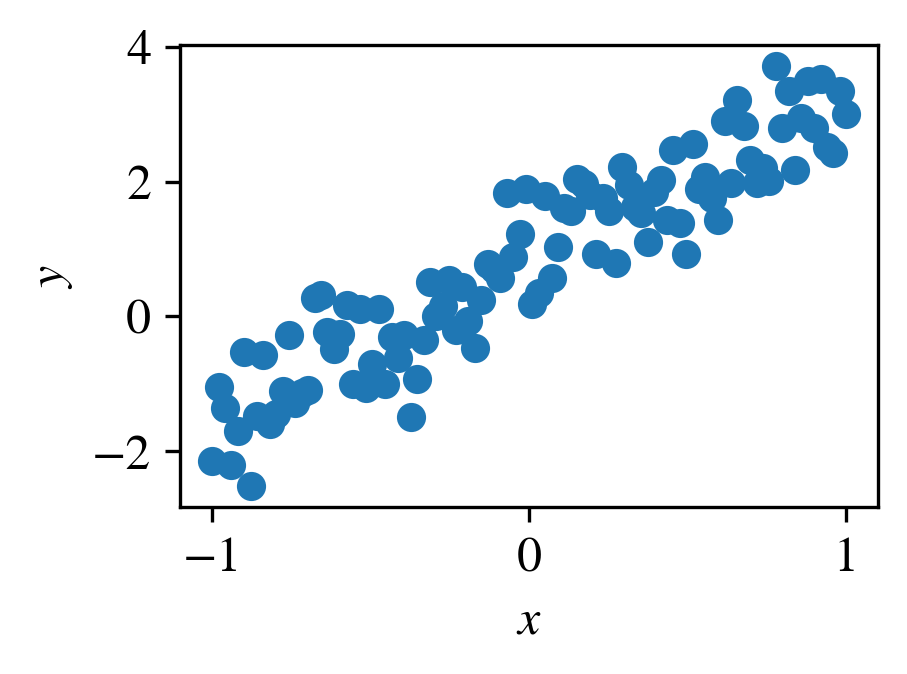

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(3, 2))

ax.scatter(x, y)
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")

plt.show()

Suppose we fix $m$ and $b$ to some values $m_0$ and $b_0$. We now have a model which is completely defined, and given some value for $x$, we can predict $y.$ But how do we know if these are good choices? We need to define a metric, or a measure of how well the model fits the data.

In [8]:
def criterion(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)

Above, our `criterion` is called the average mean squared error (MSE). The square root of this is the "root-mean-squared" error, which you are likely familiar with. There are many ways to choose which criterion you want to use, but for now the MSE will suffice. In machine learning lingo, it's called a "hyper parameter" (which we can discuss more later). 

## Evaluating an arbitrary model using a "random" optimizer

We know what the ground truth slope `m` and y-intercept `b` actually are, but let's pretend we don't, and evaluate a set of linear models against the data that we have. We can take a bunch of values for `m0` (guesses for the slope) and `b0` (guesses for the y-intercept), create a linear model with those parameters, and evaluate those against the actual data.

In [9]:
np.random.seed(123)
m0 = np.random.random(size=100) * 6 - 3  # 100 random numbers between -3 and 3
b0 = np.random.random(size=100)          # 100 random numbers between 0 and 1

Let's try every one of these combinations for `m0` and `b0`, and valuate the model against our data.

In [10]:
import pandas as pd
from itertools import product

In [11]:
m0b0 = list(product(m0, b0))

In [12]:
df = pd.DataFrame({
    "m0": [params[0] for params in m0b0],
    "b0": [params[1] for params in m0b0],
    "criterion": [criterion(y, linear_model(x, *params)) for params in m0b0]
})

In [13]:
df

,m0,b0,criterion
0,1.178815,0.513128,0.921456
1,1.178815,0.666625,0.852788
2,1.178815,0.105908,1.331962
3,1.178815,0.130895,1.297224
4,1.178815,0.321981,1.072844
...,...,...,...
9995,-0.939264,0.635900,4.157712
9996,-0.939264,0.032198,4.736670
9997,-0.939264,0.744781,4.130881
9998,-0.939264,0.472913,4.242188


In [14]:
argmin = df["criterion"].argmin()

In [15]:
df.iloc[argmin, :]

m0           2.360335
b0           0.814844
criterion    0.318958
Name: 3765, dtype: float64

## ⚠️ Check your understanding/Discussion

What happened here?

## A smarter optimizer: gradient descent

It stands to reason that just randomly guessing parameters is probably not the most effective way of finding the right guess. Can we do better? Absolutely! [Gradient descent](https://en.wikipedia.org/wiki/Gradient_descent), and its family of related methods (you may have heard of [Adam](https://arxiv.org/abs/1412.6980)), can be used to find an optimal set of parameters for arbitrary models.

Gradient descent, and its related methods, are all about finding the optima of functions. For example, if I give you a function $f(x) = (x-2)^2$ and ask you to find its minimum, how would you do this. From calculus, you might know how. You also might recognize this is a simple parabola and know the answer right away. But what about some arbitrary function, possibly with many _local_ minima, and possibly a _huge_ number of parameters (in machine learning, this number can easily be greater than $10^7$)? Gradient descent is a method for finding minima numerically.

Given a function $f(x)$ and its derivative $\nabla f(x),$ the general rule of gradient descent is that to find a point closer to the actual minimum of $f,$ we follow its gradient:

$$x_{n+1} = x_n - \gamma \nabla f(x_n).$$

This is perhaps easiest to see through an example. Let's consider the function $f(x) = (x-2)^2,$ which of course has derivative $df(x)/dx = 2(x-2).$

In [16]:
def gradient_descent(x0, f_prime, gamma, N=100):
    """The gradient descent algorithm for a scalar function.
    
    Parameters
    ----------
    x0 : float
        The initial guess for the minimum.
    f_prime : callable
        The derivative of the function of interest.
    gamma : float
        Learning rate.
    N : int
        Number of iterations.
        
    Returns
    -------
    list
        A list of the values of x found during gradient descent.
    """
    
    guesses = [x0]
    for _ in range(N):
        x_n = guesses[-1]
        guesses.append(x_n - gamma * f_prime(x_n))
    return guesses

In [17]:
points = np.array(gradient_descent(
    x0=10.0,
    f_prime=lambda x: 2.0 * (x - 2.0),
    gamma=0.1,
    N=100
))

We of course know that the true minimum of this function is at $x=2,$ but lets plot how well the `gradient_descent` function finds this minimum.

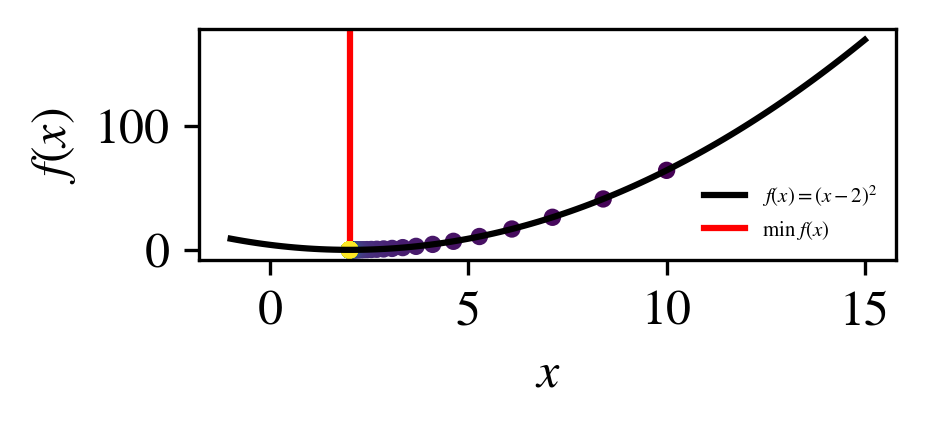

In [18]:
cmap = mpl.colormaps["viridis"].resampled(len(points))

fig, ax = plt.subplots(1, 1, figsize=(3, 1))

xgrid = np.linspace(-1, 15, 100)
ax.plot(xgrid, (xgrid - 2.0)**2, "k-", label=r"$f(x)=(x-2)^2$")
ax.scatter(points, (points - 2.0)**2, c=[cmap(ii) for ii in range(len(points))], s=10)
ax.axvline(2.0, zorder=-1, color="red", label="min $f(x)$")
ax.legend(frameon=False, fontsize=5)

ax.set_xlabel("$x$")
ax.set_ylabel("$f(x)$")

plt.show()

## ⚠️ Check your understanding/Discussion

Play around with the above code a bit. Here are some examples of things you can try.
- What happens if you make $\gamma$ really large?
- What happens if you make $\gamma$ really small?
- What happens if you change $x_0$?
- What happens if you change the function? For example, try $f(x) = \sin x$ (remember the derivative from calculus?). How sensitive is this procedure to your choice of $x_0$?

Here's a [video](https://upload.wikimedia.org/wikipedia/commons/transcoded/4/4c/Gradient_Descent_in_2D.webm/Gradient_Descent_in_2D.webm.720p.vp9.webm) of what gradient descent is doing with a lot of points. This arbitrary function is two dimensional. If you are not sure what's happening here, ask!

## Minimizing the loss function

Now we put two pieces together. As a reminder, the criterion, which we will now refer to as a loss function, is a measure of how different two data points are. We wish to minimize the average of this loss function when doing machine learning. 

For example, consider the linear fit from before. Our ground truth "training data" is $\{x_i, y_i\},$ and our model is simply $f(x; m, b) = mx + b$. We want to _minimize_ the difference between the ground truth values and predicted values on our dataset:

$$ L(m, b) = \frac{1}{N} \sum_{i=1}^N (y_i - f(x_i; m, b))^2 $$

Specifically, we want to minimize $L$ with respect to $m$ and $b.$ Stated slightly differently, we want to find the corresponding values of $m, b$ such that $L$ is minimized. We just learned of a way to do this, gradient descent! However, to use gradient descent, we need the partial derivatives of $L$ with respect to all parameters of interest. Luckily, $L$ is differentiable analytically.

NOTE: ALL machine learning models trained with the family of gradient descent methods have to have analytically known derivatives. This includes neural networks!

The derivatives are:

$$ \frac{\partial L(m, b)}{\partial m} = -\frac{2}{N}\sum_{i=1}^N (y_i - f(x_i; m, b)) x_i$$

and

$$ \frac{\partial L(m, b)}{\partial b} = -\frac{2}{N}\sum_{i=1}^N (y_i - f(x_i; m, b)).$$

Following the rule from before, the update rules for $m$ and $b$ are:

$$ m_{n+1} = m_n - \gamma \frac{\partial L(m, b)}{\partial m}$$

and

$$ b_{n+1} = b_n - \gamma \frac{\partial L(m, b)}{\partial b}.$$

In [19]:
def gradient_descent_linear_model(x, y, m0, b0, gamma=0.1, N=100):
    b = [b0]
    m = [m0]

    for _ in range(N):
        
        y_pred = linear_model(x, m[-1], b[-1])
        
        # Calculate the derivatives of the loss function
        dLdm = -2.0 / len(x) * np.sum(x * (y - y_pred))
        dLdb = -2.0 / len(x) * np.sum(y - y_pred)
        
        # Update
        m.append(m[-1] - gamma * dLdm)
        b.append(b[-1] - gamma * dLdb)

    return m, b

In [20]:
m, b = gradient_descent_linear_model(x, y, m0=-1.9, b0=-5.0, gamma=0.1, N=100)

If we plot the convergence of `m` and `b` as a function of "epoch" (or number of full passes through the training data) we can see a very fast convergence of the parameters to the true parameters, which are $m = 0.8$ and $b=2.4$:

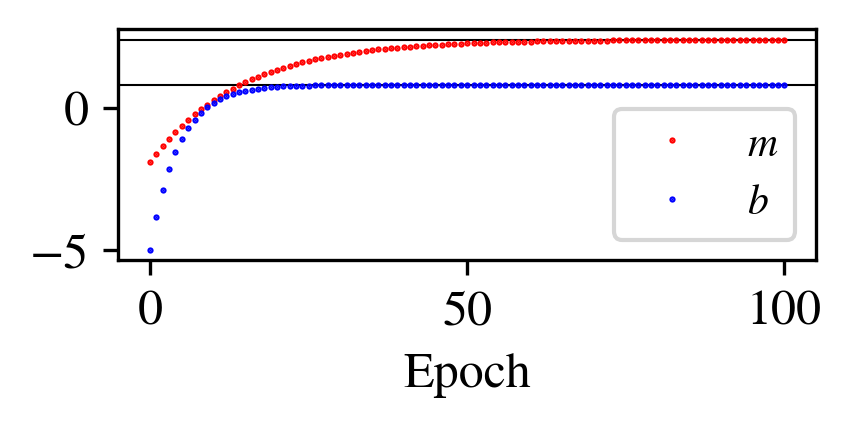

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(3, 1))

ax.axhline(0.8, color="black", linewidth=0.5)
ax.axhline(2.4, color="black", linewidth=0.5)

ax.plot(m, "ro-", linewidth=0, markersize=0.5, label="$m$")
ax.plot(b, "bo-", linewidth=0, markersize=0.5, label="$b$")

ax.legend()

ax.set_xlabel("Epoch")

plt.show()

We can also plot the linear fit itself as a function of epoch.

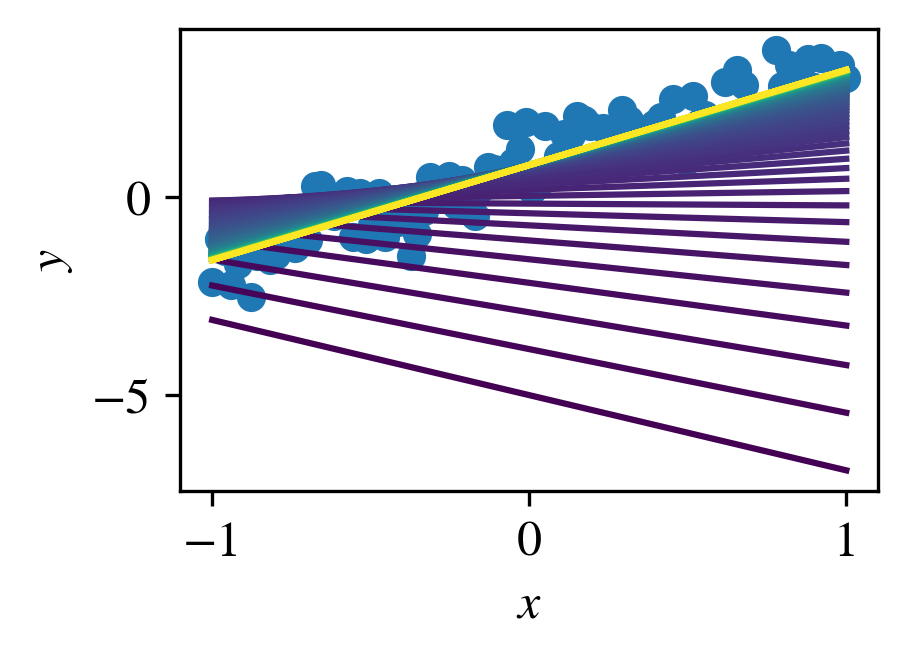

In [22]:
cmap = mpl.colormaps["viridis"].resampled(len(m))
grid = np.linspace(-1, 1, 100)

fig, ax = plt.subplots(1, 1, figsize=(3, 2))



for ii, (mm, bb) in enumerate(zip(m, b)):
    ax.plot(grid, linear_model(grid, mm, bb), color=cmap(ii))
    
ax.scatter(x, y, zorder=1)

ax.set_xlabel("$x$")
ax.set_ylabel("$y$")

plt.show()

## ⚠️ Check your understanding/Discussion

As with the previous section, understanding what's going on here is critical. Once again, ask and answer (discuss with your neighbors), what is going on here? **If you can understand this simple example, you will be able to understand all of gradient-based machine learning that we present as part of this tutorial series!**

## California housing dataset

Let's apply the knowledge we've gained from the previous sections on a "real" problem. We'll be using the [California Housing Dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html), which is a classic teaching example in machine learning. We'll also loosely follow along with this [tutorial](https://towardsdatascience.com/introduction-to-regression-analysis-9151d8ac14b3).

In [23]:
from sklearn.datasets import fetch_california_housing

In [24]:
data = fetch_california_housing()

# Put the data into a cleaner format:
df = pd.DataFrame({key: data["data"].T[ii] for ii, key in enumerate(data["feature_names"])})
df[data["target_names"][0]] = data["target"]

Before we fit anything, let's do some exploratory data analysis.

In [25]:
df["MedHouseVal"].max()

5.00001

In [26]:
df["MedHouseVal"].min()

0.14999

In [27]:
df.corr()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
MedInc,1.000000,-0.119034,0.326895,-0.062040,0.004834,0.018766,-0.079809,-0.015176,0.688075
HouseAge,-0.119034,1.000000,-0.153277,-0.077747,-0.296244,0.013191,0.011173,-0.108197,0.105623
AveRooms,0.326895,-0.153277,1.000000,0.847621,-0.072213,-0.004852,0.106389,-0.027540,0.151948
AveBedrms,-0.062040,-0.077747,0.847621,1.000000,-0.066197,-0.006181,0.069721,0.013344,-0.046701
Population,0.004834,-0.296244,-0.072213,-0.066197,1.000000,0.069863,-0.108785,0.099773,-0.024650
AveOccup,0.018766,0.013191,-0.004852,-0.006181,0.069863,1.000000,0.002366,0.002476,-0.023737
Latitude,-0.079809,0.011173,0.106389,0.069721,-0.108785,0.002366,1.000000,-0.924664,-0.144160
Longitude,-0.015176,-0.108197,-0.027540,0.013344,0.099773,0.002476,-0.924664,1.000000,-0.045967
MedHouseVal,0.688075,0.105623,0.151948,-0.046701,-0.024650,-0.023737,-0.144160,-0.045967,1.000000


The strongest correlation between our inputs and outputs comes from the `HouseAge`, `AveRooms` and especially `MedInc`. We'll use these three variables as part of a multilinear regression model:

$$ f(x_1, x_2, x_3) = c_0 + c_1 x_1 + c_2 x_2 + c_3 x_3, $$

where $x_1, x_2, x_3$ are the values of the three input variables.

Although there is not much linear correlation between latitude and longitude and our target, we can still make a pretty plot. Kinda looks like California!

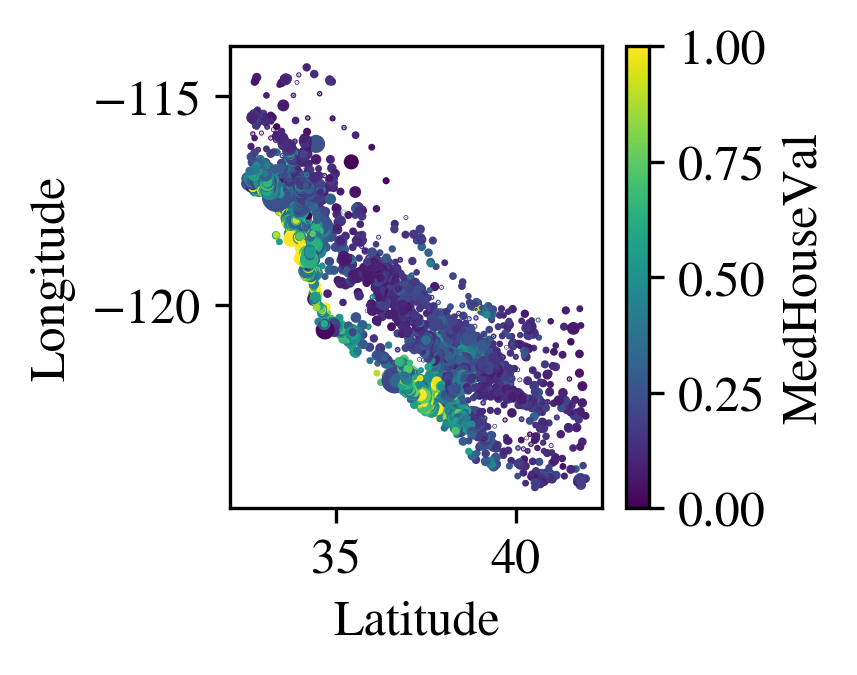

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(2, 2))


ax.scatter(df['Latitude'], df['Longitude'], c=df['MedHouseVal'], s=df['Population']/1000)
cbar = fig.colorbar(mpl.cm.ScalarMappable(), ax=ax)
ax.set_xlabel("Latitude")
ax.set_ylabel("Longitude")
cbar.set_label("MedHouseVal")

plt.show()

## ⚠️ Check your understanding/Discussion

Train a multilinear regression model using gradient descent on the California Housing dataset.

## Training and testing

In machine learning, and in any data-driven modeling, we have to "fit" the model on some dataset, but then we want an unbiased estimation of how the model will perform on data it has not yet seen before. We can easily do this with the `sci-kit learn` library.

In [29]:
X = df[["HouseAge", "AveRooms", "MedInc"]].to_numpy()
y = df["MedHouseVal"].to_numpy()

In [30]:
from sklearn.model_selection import train_test_split

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=123)

Now let's train a linear model. Since you've already done this the hard way, now we can do it the easy way (using existing libraries)! It's also relevant to note that unlike in most machine learning problems (which use non-linear models), linear models can be fit analytically (and quickly).

In [32]:
from sklearn.linear_model import LinearRegression

In [33]:
model = LinearRegression()

In [34]:
model.fit(X_train, y_train)

LinearRegression()

In [35]:
model.coef_

array([ 0.01661202, -0.02541556,  0.44263032])

In [36]:
model.intercept_

0.015671187151787613

From the trained model parameters, the linear equation is approximately

$$ f(x_1, x_2, x_3) = 0.016 + 0.017 x_1 - 0.025 x_2 + 0.443 x_3 $$

As before, we want to quantify the degree of fit. We can once again use the criterion to determine the quality of the fit. Let's do this on both the training and testing data.

In [37]:
criterion(y_train, model.predict(X_train))

0.6475707651036474

In [38]:
criterion(y_test, model.predict(X_test))

0.6687870550267007

Given that the range of the target is roughly 5, this is not a terrible model. We can likely do better by including more variables, or by making our model more complex (which we will explore in future tutorials).

## ⚠️ Check your understanding/Discussion

What is the point of a train/test split?

# Logistic Regression

Logistic regression is a slight modification of linear regression that allows for categorical targets. There are multiple types of logistic regression, but for this tutorial, we will focus on _binary_ logistic regression: when the target value can be "on or off": 0 or 1.

Consider the previous linear regression model of a single variable: $f(x) = mx + b$. The range, or set of possible values, that $f(x)$ can take on is infinite: $f(x) \in (-\infty, \infty).$ This is appropriate, in general, for regression problems in which the output can take on any value, but in classification problems, we want the model to essentially represent the probability of being one of the two classes.

So, for logistic regresion, we add an extra step:

$$g(x) = \sigma(f(x))$$

where 

$$\sigma(x) = \frac{1}{1 + e^{-x}}$$

is called the _sigmoid function_. The sigmoid function has the property of being bounded between 0 and 1, making it a convenient choice for our purposes.

In [6]:
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

Text(0, 0.5, '$\\sigma(x)$')

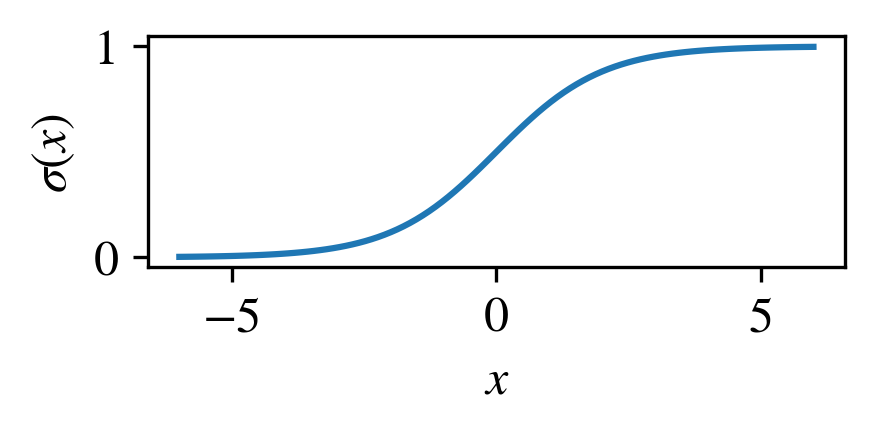

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(3, 1))

grid = np.linspace(-6, 6, 100)
ax.plot(grid, sigmoid(grid))
ax.set_xlabel("$x$")
ax.set_ylabel("$\sigma(x)$")

## ⚠️ Check your understanding/Discussion

The output of $\sigma(x)$ is of course continuous. How can we get a discrete output from this?

## New dataset

We'll use the [Iris Dataset](https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html), downloaded from sklearn, for this section. From sklearn:

> This data sets consists of 3 different types of irises’ (Setosa, Versicolour, and Virginica) petal and sepal length, stored in a 150x4 numpy.ndarray. The rows being the samples and the columns being: Sepal Length, Sepal Width, Petal Length and Petal Width.

The targets of this dataset are the type of flower, which we will represent as _categorical variables_ 0, 1, and 2. Since we're doing _binary_ logistic regression, we're going to do what is called a "one vs. all" approach, and see if we can predict whether or not an input corresponds to class 0, or not class 0 (either 1 or 2).

In [12]:
from sklearn.datasets import load_iris

In [13]:
iris = load_iris()

In [17]:
X = iris["data"]

In [18]:
y = iris["target"]

In [19]:
# one vs all!
y[y == 2] = 1

## New loss function

While you certainly can use the mean squared error criterion from before, there is actually a better choice: it's called the _cross-entropy loss function_. It turns out that for logistic regression, the cross entropy loss is _convex_, meaning we are guaranteed to converge to the global minimum and find the absolute best fit of our model. The cross entropy loss is given by:

$$J(\hat{y}, y) = -y \ln \hat{y} - (1-y) \ln (1-\hat{y}),$$

and the total loss over the dataset:

$$L(m, b) = \frac{1}{N} \sum_{i=1}^N J(g(x_i), y_i).$$

## ⚠️ Check your understanding/Discussion

- Describe the properties of this new loss function.
- What happens when $y=0$ or $\hat{y}=0$?
- What happens when $y=1$ or $\hat{y}=1$?

## Gradient update rule

As before, we can take the derivative of $L$ with respect to its parameters (which are implicitly in $g$) to figure out our update rule for gradient descent.

Remember, our functions are

$$f(x) = c_0 + c_1x $$

(which is the same as $f(x) = mx + b$ but written in a slightly more general form, you'll see why later), and

$$g(x) = \sigma(f(x)).$$

Let's work through it. Using chain rule,

$$ \frac{\partial L}{\partial c_i} = \frac{1}{N} \sum_{i=1}^N \frac{\partial J}{\partial \sigma} \frac{\partial \sigma}{\partial f} \frac{\partial f}{\partial c_i}$$

Working through each of these partial derivatives is a bit tedious, but it's not too bad:

$$J(\sigma, y) = -y \ln \sigma - (1-y)\ln (1-\sigma) \Rightarrow  \frac{\partial J}{\partial \sigma} = -\frac{y}{\sigma} + \frac{1-y}{1-\sigma}$$

$$\sigma(f) = \frac{1}{1 + e^{-f}} \Rightarrow \frac{\partial \sigma}{\partial f} = \frac{e^f}{(1+e^f)^2} = \sigma(f) (1-\sigma(f))$$

$$\frac{\partial f}{\partial c_i} = x_i$$

## ⚠️ Check your understanding/Discussion

Code up the model training algorithm for a logistic regressor and use it on the iris dataset. If you don't have enough time, use the built in one in Scikit Learn!